In [2]:
%matplotlib inline
import torch
import math
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

In [11]:
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model



def train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)     # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, train_acc, None))
        
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                scheduler.step()
            else:
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')

train loss 0.145, train acc 0.945, test acc 0.890


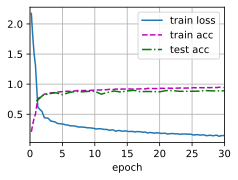

In [12]:
loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

lr, num_epochs = .3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

In [14]:
print(trainer.param_groups[0]['lr'])

0.3


In [22]:
class SquareRootScheduler:
    def __init__(self, lr=.1) -> None:
        self.lr = lr
    
    def __call__(self, num_update):
        return lr / pow(1 + num_update, .5)

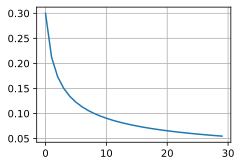

In [23]:
scheduler = SquareRootScheduler()
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.204, train acc 0.924, test acc 0.896


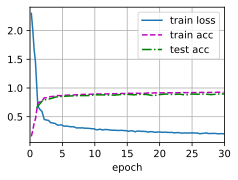

In [24]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

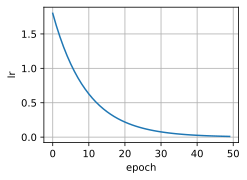

In [25]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr
    
    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.factor * self.base_lr)
        return self.base_lr

scheduler = FactorScheduler(.9, 1e-2, 2.)
d2l.plot(torch.arange(50), [scheduler(i) for i in range(50)], xlabel='epoch', ylabel='lr')

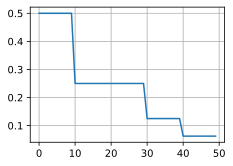

In [27]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[10, 30, 40], gamma=.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(50), [get_lr(trainer, scheduler) for t in range(50)])

train loss 0.253, train acc 0.906, test acc 0.874


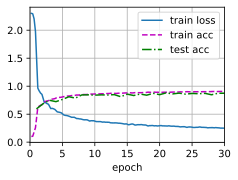

In [28]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

In [ ]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=.01, final_lr=0, warmup_steps=0, warmup_begin_lr=0) -> None:
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase
    
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (self.base_lr_orig - self.final_lr) / 2 * (1 + math.cos(math.pi * (epoch - self.warmup_steps) / self.max_steps))
            return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=.3, final_lr=.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

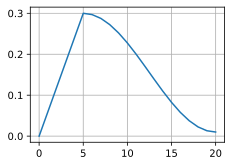

In [32]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=.3, final_lr=.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

TypeError: bad operand type for unary -: 'NoneType'

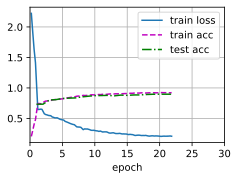

In [33]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)